## Momentum Trading

Trend-following trading strategy that beats buy-hold positions in the long term across a wide range of assets.

In [139]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

### Data Fetching and Initial Engineering

In [140]:
asset_ticker = "^HSI"

In [141]:
asset = yf.download(asset_ticker).xs(asset_ticker,axis=1,level=1)
day = np.arange(1, len(asset.index)+1)
asset['day'] = day
asset = asset[['day', 'Open', 'High', 'Low', 'Close']]
asset.tail()

[*********************100%***********************]  1 of 1 completed


Price,day,Open,High,Low,Close
Date,,,,,
2026-01-07,9630,26601.830078,26616.939453,26313.509766,26458.949219
2026-01-08,9631,26302.779297,26305.689453,25960.339844,26149.310547
2026-01-09,9632,26272.539062,26299.320312,26114.410156,26231.789062
2026-01-12,9633,26376.839844,26608.480469,26187.759766,26608.480469
2026-01-13,9634,26958.519531,27143.660156,26729.539062,26848.470703


In [142]:
asset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9634 entries, 1986-12-31 to 2026-01-13
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   day     9634 non-null   int64  
 1   Open    9634 non-null   float64
 2   High    9634 non-null   float64
 3   Low     9634 non-null   float64
 4   Close   9634 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 451.6 KB


### Moving Average Calculation

In [143]:
asset['9-day SMA'] = asset['Close'].rolling(9).mean()
asset['21-day SMA'] = asset['Close'].rolling(21).mean()

In [144]:
asset['signal'] = np.where(asset['9-day SMA'] > asset['21-day SMA'], 1, 0)
asset['signal'] = np.where(asset['21-day SMA'] > asset['9-day SMA'], -1, asset['signal'])
asset.dropna(inplace=True, axis=0)

In [145]:
asset.head()

Price,day,Open,High,Low,Close,9-day SMA,21-day SMA,signal
Date,,,,,,,,
1987-02-02,21,2585.199951,2585.199951,2585.199951,2585.199951,2514.166612,2549.042841,-1
1987-02-03,22,2606.399902,2606.399902,2606.399902,2606.399902,2530.377713,2550.857120,-1
1987-02-04,23,2636.600098,2636.600098,2636.600098,2636.600098,2551.122179,2555.452358,-1
1987-02-05,24,2672.399902,2672.399902,2672.399902,2672.399902,2566.511068,2561.166643,1
1987-02-06,25,2673.600098,2673.600098,2673.600098,2673.600098,2581.699978,2565.438081,1


asset['signal'].shift(1) is done to make sure that the position is entered after the signal is visible, i.e. prevent look-ahead bias.

In [146]:
asset['return'] = np.log(asset['Close']).diff()
asset['system_return'] = asset['signal'].shift(1) * asset['return']
asset['entry'] = asset['signal'].diff()
asset.head(100)

Price,day,Open,High,Low,Close,9-day SMA,21-day SMA,signal,return,system_return,entry
Date,,,,,,,,,,,
1987-02-02,21,2585.199951,2585.199951,2585.199951,2585.199951,2514.166612,2549.042841,-1,NaN,NaN,NaN
1987-02-03,22,2606.399902,2606.399902,2606.399902,2606.399902,2530.377713,2550.857120,-1,0.008167,-0.008167,0.0
1987-02-04,23,2636.600098,2636.600098,2636.600098,2636.600098,2551.122179,2555.452358,-1,0.011520,-0.011520,0.0
1987-02-05,24,2672.399902,2672.399902,2672.399902,2672.399902,2566.511068,2561.166643,1,0.013487,-0.013487,2.0
1987-02-06,25,2673.600098,2673.600098,2673.600098,2673.600098,2581.699978,2565.438081,1,0.000449,0.000449,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1987-06-22,116,3131.199951,3131.199951,3131.199951,3131.199951,3133.700005,3033.409552,1,-0.010926,-0.010926,0.0
1987-06-23,117,3110.399902,3110.399902,3110.399902,3110.399902,3133.899984,3044.809547,1,-0.006665,-0.006665,0.0
1987-06-24,118,3179.000000,3179.000000,3179.000000,3179.000000,3142.977756,3058.209542,1,0.021815,0.021815,0.0


Text(0.5, 1.0, '^HSI Momentum Strategy')

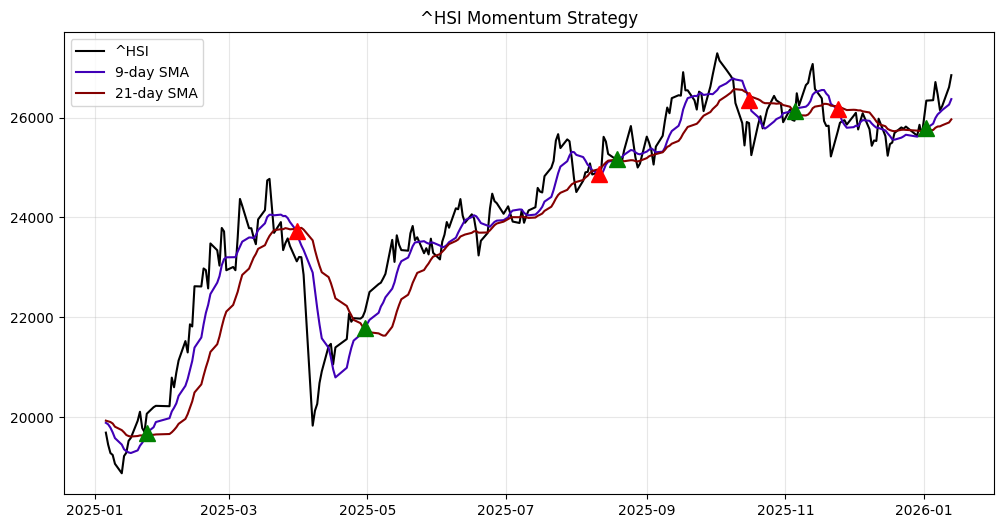

In [147]:
plt.rcParams['figure.figsize'] = 12, 6
plt.grid(True, alpha = 0.3)
plt.plot(asset.iloc[-252:]['Close'], label = f'{asset_ticker}', color="#000000")
plt.plot(asset.iloc[-252:]['9-day SMA'], label = '9-day SMA', color = "#4000B7")
plt.plot(asset.iloc[-252:]['21-day SMA'], label = '21-day SMA', color = "#840000")
plt.plot(asset[-252:].loc[asset.entry==2].index, asset[-252:]['9-day SMA'][asset.entry == 2], '^', color = 'g', markersize=12)
plt.plot(asset[-252:].loc[asset.entry == -2].index, asset[-252:]['9-day SMA'].loc[asset.entry == -2], '^', color='r', markersize=12)
plt.legend()
plt.title(f'{asset_ticker} Momentum Strategy')

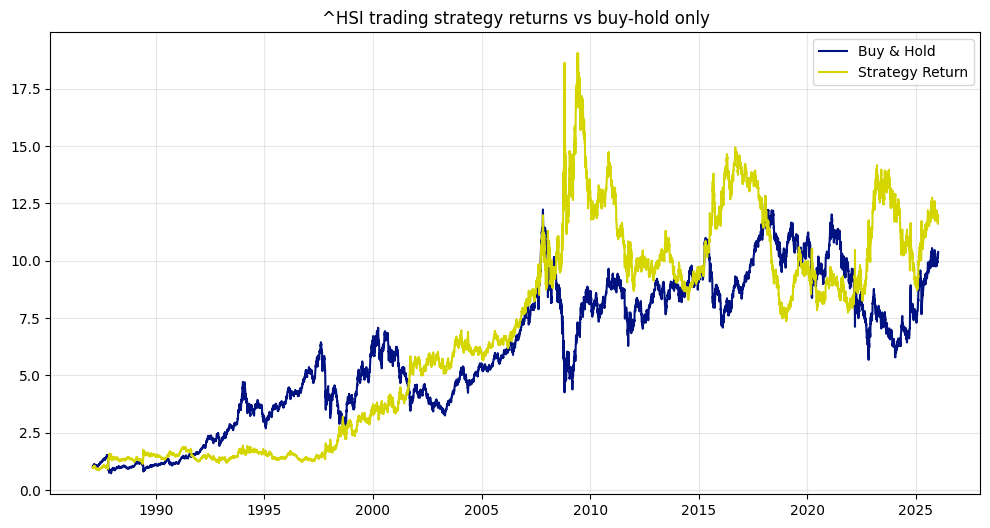

In [148]:
plt.plot(np.exp(asset['return']).cumprod(), label = 'Buy & Hold', color = "#001181")
plt.plot(np.exp(asset['system_return']).cumprod(), label = 'Strategy Return', color = "#D5D500")
plt.legend()
plt.title(f'{asset_ticker} trading strategy returns vs buy-hold only')
plt.grid(True, alpha = 0.3)

In [149]:
np.exp(asset['return']).cumprod()-1

Date
1987-02-02         NaN
1987-02-03    0.008201
1987-02-04    0.019882
1987-02-05    0.033730
1987-02-06    0.034195
                ...   
2026-01-07    9.234779
2026-01-08    9.115005
2026-01-09    9.146909
2026-01-12    9.292620
2026-01-13    9.385452
Name: return, Length: 9614, dtype: float64

In [150]:
np.exp(asset['system_return']).cumprod()-1

Date
1987-02-02          NaN
1987-02-03    -0.008134
1987-02-04    -0.019495
1987-02-05    -0.032630
1987-02-06    -0.032195
                ...    
2026-01-07    10.747943
2026-01-08    10.610462
2026-01-09    10.647083
2026-01-12    10.814336
2026-01-13    10.920893
Name: system_return, Length: 9614, dtype: float64

### The strategy, over a long period, creates a market-beating returns on the Hang Seng Index (HSI) by a moderate margin.

#### Notice that the effect of the trading strategy vaires a lot from asset to asset.